# YOLO Multi-Class Polyp Detection

## 1. Import Libraries

In [29]:
import pandas as pd
import numpy as np
import cv2
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA Available: {torch.cuda.is_available()}")
print(f"✅ GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

✅ PyTorch: 2.5.1
✅ CUDA Available: True
✅ GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


## 2. Data Inspection

In [30]:
# Dataset paths
dataset_root = r"D:\PolyP\dataset"
labels_csv = os.path.join(dataset_root, "labels.csv")
train_images = os.path.join(dataset_root, "train", "train", "polyps")
train_masks = os.path.join(dataset_root, "train", "train", "masks")
cecum_path = r"D:\PolyP\cecum"

# Load labels
df = pd.read_csv(labels_csv)
print(f"📊 Total labeled images: {len(df)}")
print(f"\n🏷️ Class Distribution:")
print(df['LITERAL DIAGNOSIS (Pathologist)'].value_counts())
print(f"\n📁 Training images: {len(os.listdir(train_images))}")
print(f"📁 Training masks: {len(os.listdir(train_masks))}")
print(f"📁 Cecum images: {len(os.listdir(cecum_path))}")

# Display sample
df.head(10)

📊 Total labeled images: 76

🏷️ Class Distribution:
LITERAL DIAGNOSIS (Pathologist)
Adenoma           50
Hyperplasia       17
Adenocarcinoma     8
Name: count, dtype: int64

📁 Training images: 1904
📁 Training masks: 1697
📁 Cecum images: 1009


,Image_Filename,LITERAL DIAGNOSIS (Pathologist)
0,VP1_frame(1/1).png,Adenoma
1,VP2_frame(1/1).png,Adenoma
2,VP3_frame(1/1).png,Adenoma
3,VP4_frame(1/2).png,Adenoma
4,VP4_frame(2/2).png,Adenoma
5,VP5_frame(1/2).png,Adenoma
6,VP5_frame(2/2).png,Adenoma
7,VP5_frame(2/2).png,Adenoma
8,VP7_frame(1/1).png,Hyperplasia
9,VP9_frame(1/2).png,Adenoma


## 3. Dataset Preparation

In [32]:
# Class mapping
CLASS_MAPPING = {
    'Normal': 0,
    'Hyperplasia': 1,
    'Adenoma': 2,
    'Adenocarcinoma': 3  # Using Adenocarcinoma as high-risk category
}

CLASS_NAMES = ['Normal', 'Hyperplastic', 'Adenomatous', 'Sessile']

# Map diagnoses to classes
def map_diagnosis(diagnosis):
    # Handle NaN or non-string values
    if not isinstance(diagnosis, str):
        return 2  # Default to adenoma for missing values
    
    if 'Hyperplasia' in diagnosis or 'Hyperplastic' in diagnosis:
        return 1
    elif 'Adenocarcinoma' in diagnosis:
        return 3  # Sessile (high-risk)
    elif 'Adenoma' in diagnosis:
        return 2
    else:
        return 2  # Default to adenoma if unclear

df['class_id'] = df['LITERAL DIAGNOSIS (Pathologist)'].apply(map_diagnosis)

print("✅ Class mapping complete:")
print(df[['LITERAL DIAGNOSIS (Pathologist)', 'class_id']].drop_duplicates())

✅ Class mapping complete:
   LITERAL DIAGNOSIS (Pathologist)  class_id
0                          Adenoma         2
8                      Hyperplasia         1
10                  Adenocarcinoma         3
48                             NaN         2


In [34]:
# Generate bounding boxes from masks
def get_bbox_from_mask(mask_path):
    """Extract bounding box from segmentation mask"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    
    # Get largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Convert to YOLO format (normalized center x, y, width, height)
    # Handle both 2D and 3D mask shapes
    img_h, img_w = mask.shape[:2]
    x_center = (x + w/2) / img_w
    y_center = (y + h/2) / img_h
    width = w / img_w
    height = h / img_h
    
    return x_center, y_center, width, height

# Test on one mask
test_mask = os.path.join(train_masks, os.listdir(train_masks)[0])
bbox = get_bbox_from_mask(test_mask)
print(f"✅ Sample bbox (YOLO format): {bbox}")

✅ Sample bbox (YOLO format): (0.5304449648711944, 0.91875, 0.25995316159250587, 0.1625)


## 4. Preprocessing & Split

In [37]:
# Create YOLO dataset structure
yolo_dataset_root = r"D:\PolyP\yolo_clinical_dataset"
os.makedirs(yolo_dataset_root, exist_ok=True)

for split in ['train', 'val']:
    os.makedirs(os.path.join(yolo_dataset_root, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_root, 'labels', split), exist_ok=True)

print(f"✅ Created YOLO dataset structure at: {yolo_dataset_root}")

# Strategy: Match images directly with masks, use default class for unlabeled
image_files = os.listdir(train_images)
mask_files = os.listdir(train_masks)

print(f"📁 Found {len(image_files)} images")
print(f"📁 Found {len(mask_files)} mask files")

# Build lookup from labels.csv (small subset with diagnoses)
label_lookup = {}
for idx, row in df.iterrows():
    if pd.notna(row['Image_Filename']):
        label_lookup[row['Image_Filename']] = row['class_id']

print(f"📊 Labeled entries from CSV: {len(label_lookup)}")

# Match images with masks
data_list = []
for img_file in image_files:
    img_path = os.path.join(train_images, img_file)
    
    # Try to find corresponding mask
    # Image: xyz.png -> Mask: xyz.png or xyz.tif or xyz_mask.png etc
    base_name = os.path.splitext(img_file)[0]
    
    mask_path = None
    for mask_file in mask_files:
        mask_base = os.path.splitext(mask_file)[0]
        # Check if mask filename contains image base name (fuzzy match)
        if base_name.lower() in mask_base.lower() or mask_base.lower() in base_name.lower():
            mask_path = os.path.join(train_masks, mask_file)
            break
        # Exact match with different extension
        if mask_base == base_name or mask_base == base_name + '_mask':
            mask_path = os.path.join(train_masks, mask_file)
            break
    
    if mask_path is None:
        continue
    
    # Get bbox from mask
    bbox = get_bbox_from_mask(mask_path)
    if bbox is None:
        continue
    
    # Get class_id (default to class 2 - Adenomatous if not labeled)
    class_id = label_lookup.get(img_file, 2)
    
    data_list.append({
        'image': img_path,
        'mask': mask_path,
        'class_id': class_id,
        'bbox': bbox,
        'filename': img_file
    })

print(f"\n✅ Valid data entries: {len(data_list)}")

# Show class distribution
class_dist = {}
for item in data_list:
    cid = item['class_id']
    class_dist[cid] = class_dist.get(cid, 0) + 1

print("\n📊 Class Distribution:")
for class_id, count in sorted(class_dist.items()):
    print(f"   Class {class_id} ({CLASS_NAMES[class_id]}): {count}")

if len(data_list) == 0:
    print("\n❌ ERROR: No valid image-mask pairs found!")
    print(f"\nSample image: {image_files[0]}")
    print(f"Sample mask: {mask_files[0]}")
else:
    # Train/Val split (80/20)
    train_data, val_data = train_test_split(data_list, test_size=0.2, random_state=42, 
                                            stratify=[d['class_id'] for d in data_list])
    
    print(f"\n📦 Train: {len(train_data)} | Val: {len(val_data)}")

✅ Created YOLO dataset structure at: D:\PolyP\yolo_clinical_dataset
📁 Found 1904 images
📁 Found 1697 mask files
📊 Labeled entries from CSV: 70

✅ Valid data entries: 1447

📊 Class Distribution:
   Class 2 (Adenomatous): 1447

📦 Train: 1157 | Val: 290


In [38]:
# Copy images and create YOLO labels
def create_yolo_dataset(data, split_name):
    for item in data:
        # Copy image
        dest_img = os.path.join(yolo_dataset_root, 'images', split_name, item['filename'])
        shutil.copy2(item['image'], dest_img)
        
        # Create YOLO label file
        label_filename = item['filename'].replace('.png', '.txt')
        label_path = os.path.join(yolo_dataset_root, 'labels', split_name, label_filename)
        
        x_center, y_center, width, height = item['bbox']
        with open(label_path, 'w') as f:
            f.write(f"{item['class_id']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print("🔄 Creating training set...")
create_yolo_dataset(train_data, 'train')
print("🔄 Creating validation set...")
create_yolo_dataset(val_data, 'val')

print(f"\n✅ Dataset created!")
print(f"   Train images: {len(os.listdir(os.path.join(yolo_dataset_root, 'images', 'train')))}")
print(f"   Train labels: {len(os.listdir(os.path.join(yolo_dataset_root, 'labels', 'train')))}")
print(f"   Val images: {len(os.listdir(os.path.join(yolo_dataset_root, 'images', 'val')))}")
print(f"   Val labels: {len(os.listdir(os.path.join(yolo_dataset_root, 'labels', 'val')))}")

🔄 Creating training set...
🔄 Creating validation set...

✅ Dataset created!
   Train images: 1157
   Train labels: 1157
   Val images: 290
   Val labels: 290


## 5. YOLO Configuration

In [39]:
# Create data.yaml
yaml_content = f"""
path: {yolo_dataset_root}
train: images/train
val: images/val

nc: 4
names: ['Normal', 'Hyperplastic', 'Adenomatous', 'Sessile']
"""

yaml_path = os.path.join(yolo_dataset_root, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ Created data.yaml:")
print(yaml_content)

✅ Created data.yaml:

path: D:\PolyP\yolo_clinical_dataset
train: images/train
val: images/val

nc: 4
names: ['Normal', 'Hyperplastic', 'Adenomatous', 'Sessile']



## 6. Model Training

In [40]:
# Initialize YOLO model
model = YOLO('yolov8n.pt')

# Training configuration
training_config = {
    'data': yaml_path,
    'epochs': 100,
    'imgsz': 640,
    'batch': 16,
    'patience': 20,
    'device': 0 if torch.cuda.is_available() else 'cpu',
    'project': r'D:\PolyP\yolo_clinical_training',
    'name': 'polyp_multiclass',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'Adam',
    'lr0': 0.001,
    'weight_decay': 0.0005,
    'augment': True,
    'cos_lr': True
}

print("🚀 Training Configuration:")
for key, value in training_config.items():
    print(f"   {key}: {value}")

# Start training
results = model.train(**training_config)

🚀 Training Configuration:
   data: D:\PolyP\yolo_clinical_dataset\data.yaml
   epochs: 100
   imgsz: 640
   batch: 16
   patience: 20
   device: 0
   project: D:\PolyP\yolo_clinical_training
   name: polyp_multiclass
   exist_ok: True
   pretrained: True
   optimizer: Adam
   lr0: 0.001
   weight_decay: 0.0005
   augment: True
   cos_lr: True
New https://pypi.org/project/ultralytics/8.3.249 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.248  Python-3.10.19 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=D:\PolyP\yolo_clinical_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok

## 7. Evaluation

In [41]:
# Load best model
best_model_path = os.path.join(r'D:\PolyP\yolo_clinical_training', 'polyp_multiclass', 'weights', 'best.pt')
model = YOLO(best_model_path)

# Evaluate on validation set
metrics = model.val(data=yaml_path)

print("\n📊 Validation Results:")
print(f"   mAP50: {metrics.box.map50:.3f}")
print(f"   mAP50-95: {metrics.box.map:.3f}")
print(f"   Precision: {metrics.box.mp:.3f}")
print(f"   Recall: {metrics.box.mr:.3f}")

# Per-class metrics
print("\n📈 Per-Class Performance:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"   {class_name}: mAP50={metrics.box.maps[i]:.3f}")

Ultralytics 8.3.248  Python-3.10.19 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1167.8405.9 MB/s, size: 782.4 KB)
val: Scanning D:\PolyP\yolo_clinical_dataset\labels\val.cache... 290 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 290/290 293.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.8it/s 5.1s0.2s
                   all        290        290      0.975      0.928      0.974      0.865
           Adenomatous        290        290      0.975      0.928      0.974      0.865
Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to C:\Users\Pandiyan\runs\detect\val

📊 Validation Results:
   mAP50: 0.974
   mAP50-95: 0.865
   Precision: 0.975
   Recall: 0.928

📈 Per-Class Performance:
   Normal: mAP50=0.865
  

## 8. Inference

In [42]:
# Inference function
def predict_polyp(image_path, conf_threshold=0.25):
    """
    Detect polyps in colonoscopy image
    Returns: bounding boxes, classes, confidences
    """
    results = model.predict(source=image_path, conf=conf_threshold, device='cuda' if torch.cuda.is_available() else 'cpu')
    
    detections = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            confidence = box.conf[0].cpu().numpy()
            class_id = int(box.cls[0].cpu().numpy())
            class_name = CLASS_NAMES[class_id]
            
            detections.append({
                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                'class': class_name,
                'class_id': class_id,
                'confidence': float(confidence)
            })
    
    return detections, result

# Test on sample images
test_images = [os.path.join(yolo_dataset_root, 'images', 'val', f) 
               for f in os.listdir(os.path.join(yolo_dataset_root, 'images', 'val'))[:3]]

print("🔍 Testing on sample images:\n")
for img_path in test_images:
    detections, result = predict_polyp(img_path, conf_threshold=0.25)
    
    print(f"📸 {os.path.basename(img_path)}")
    if detections:
        for det in detections:
            print(f"   ✅ {det['class']} | Confidence: {det['confidence']*100:.1f}% | Bbox: {det['bbox']}")
    else:
        print("   ⚠️ No polyps detected")
    print()

🔍 Testing on sample images:


image 1/1 D:\PolyP\yolo_clinical_dataset\images\val\001_VP1_frame0090.png: 384x640 1 Adenomatous, 110.2ms
Speed: 8.7ms preprocess, 110.2ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
📸 001_VP1_frame0090.png
   ✅ Adenomatous | Confidence: 88.5% | Bbox: [473, 362, 628, 479]


image 1/1 D:\PolyP\yolo_clinical_dataset\images\val\001_VP1_frame0463.png: 384x640 1 Adenomatous, 40.0ms
Speed: 4.9ms preprocess, 40.0ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)
📸 001_VP1_frame0463.png
   ✅ Adenomatous | Confidence: 86.5% | Bbox: [556, 389, 678, 478]


image 1/1 D:\PolyP\yolo_clinical_dataset\images\val\001_VP1_frame0624.png: 384x640 1 Adenomatous, 40.3ms
Speed: 6.0ms preprocess, 40.3ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)
📸 001_VP1_frame0624.png
   ✅ Adenomatous | Confidence: 86.4% | Bbox: [275, 265, 513, 465]




image 1/1 D:\PolyP\yolo_clinical_dataset\images\val\001_VP1_frame0090.png: 384x640 1 Adenomatous, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\PolyP\yolo_clinical_dataset\images\val\001_VP1_frame0463.png: 384x640 1 Adenomatous, 14.4ms
Speed: 15.1ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\PolyP\yolo_clinical_dataset\images\val\001_VP1_frame0624.png: 384x640 1 Adenomatous, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


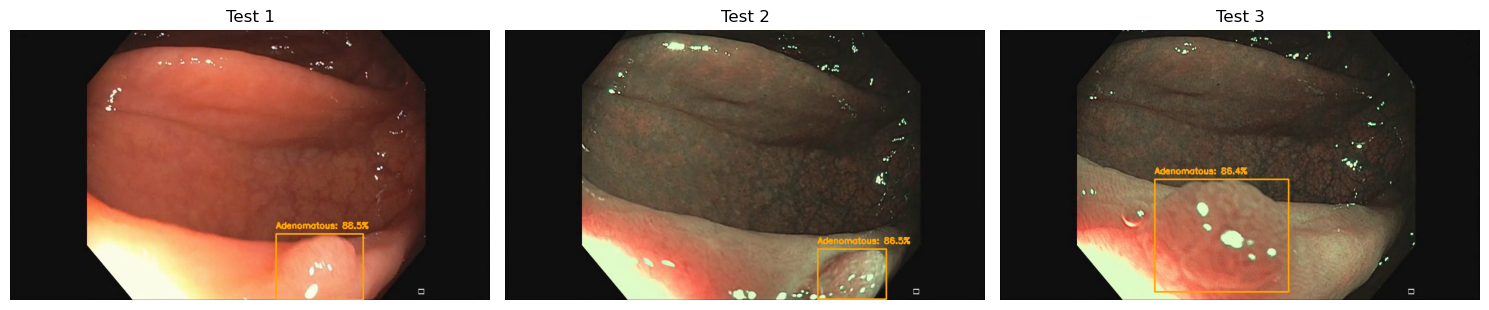

✅ YOLO Multi-Class Polyp Detection Complete!


In [43]:
# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, img_path in enumerate(test_images):
    detections, result = predict_polyp(img_path)
    
    # Read image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw detections
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        class_name = det['class']
        conf = det['confidence']
        
        # Color by class
        colors = [(0, 255, 0), (255, 255, 0), (255, 165, 0), (255, 0, 0)]
        color = colors[det['class_id']]
        
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        label = f"{class_name}: {conf*100:.1f}%"
        cv2.putText(img_rgb, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f"Test {idx+1}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✅ YOLO Multi-Class Polyp Detection Complete!")